In [19]:
#imports
import requests
import json
import pandas as pd
import numpy as np
import warnings
import random
import matplotlib.pyplot as plt
from datetime import datetime
import time as clock

start_time = clock.time()
# Sensors_Data = pd.read_json('data/W512_readings.json')
# Aircon_Data = pd.read_json('data/W512_aircon_status.json')
# Weather_Data = pd.read_json('data/Weather_data.json')

Sensors_Data = pd.read_json('../test/W512_readings1.json')
Sensors_Data_1 = pd.read_json('../test/SPGG_readings1.json') # Since w512 don have outdoor sensor yet, we will use the outdoor sensor from spgg
Aircon_Data = pd.read_json('../test/W512_aircon_status1.json')
Weather_Data = pd.read_json('../test/Weather_data1.json')

Aircon_rows = []

for _, row in Aircon_Data.iterrows():
    date = row['date']
    time = row['time']
    
    flattened_row = {
        "date": date,
        "time": time
    }
    
    fc_readings = row['FC_FullStatus_Readings']
    if fc_readings and isinstance(fc_readings, dict):
        for unit, data in fc_readings.items():
            if any(data.get("Set_Point", None) == 404.0 for data in fc_readings.values()):
                continue
            flattened_row[f"{unit}_Status"] = data.get("Status", None)
            flattened_row[f"{unit}_Fan_Status"] = data.get("Fan_Status", None)
            flattened_row[f"{unit}_Set_Point"] = data.get("Set_Point", None)
            flattened_row[f"{unit}_Operation_Mode"] = data.get("Operation_Mode", None)
    
    Aircon_rows.append(flattened_row)

Sensors_rows = []
include_keys_1 = ["24E124725E285123", "24E124725E331695","24E124725E331744",
                      "24E124725E332483","24E124725E290348","24E124725E331733","24E124725E286745","24E124725E332564" # "24E124136D316361" is supposed to be outdoor but it is not outdoor yet
                         "24E124757E150866","24E124757E150896"]

include_keys_2 = ["Sensor_1","Sensor_3","Sensor_6"]
for _, row in Sensors_Data.iterrows():
    invalid_input = False
    
    date = row['date']
    time = row['time']
    
    flattened_row = {
        "date": date,
        "time": time
    }
    
    
    lorawan_readings = row['Lorawan_Readings']
    
    if isinstance(lorawan_readings, dict):
        for unit, data in lorawan_readings.items():
            if unit not in include_keys_1:
                continue
            if isinstance(data, dict):  # Ensure that each item in Lorawan_Readings is a dictionary
                for key, value in data.items():
                    
                    flattened_row[f"{unit}_{key}"] = value
            
    energy_readings = row['Energy_Readings']
    total_power = 0
    total_energy = 0
    invalid_input_power = False
    invalid_input_energy = False
    
    if energy_readings and isinstance(energy_readings, dict):
        for unit, data in energy_readings.items():
            if unit not in include_keys_2:
                continue
            power = data.get('Power', None)
            energy = data.get('Energy', None)
            if power is None:
                invalid_input_power = True
            if energy is None:
                invalid_input_energy = True
            total_power += power
            total_energy += energy
        
    if invalid_input_power:
        total_power = None
    if invalid_input_energy:
        total_energy = None
        
    flattened_row["Total_Energy"] = total_energy
    flattened_row["Total_Power"] = total_power
    
    Sensors_rows.append(flattened_row)

Sensors_rows_1 = []
outdoor_key = ["24E124136D336145"] # this is the id of the outdoor sensor from spgg

for _, row in Sensors_Data_1.iterrows():
    invalid_input = False
    
    date = row['date']
    time = row['time']
    
    flattened_row = {
        "date": date,
        "time": time
    }
    
    
    lorawan_readings = row['Lorawan_Readings']
    
    if isinstance(lorawan_readings, dict):
        for unit, data in lorawan_readings.items():
            if unit not in outdoor_key:
                continue
            if isinstance(data, dict):  # Ensure that each item in Lorawan_Readings is a dictionary
                for key, value in data.items():
                    flattened_row[f"{unit}_{key}"] = value

    Sensors_rows_1.append(flattened_row)


# Normalize the data
Weather_rows = []

for _, row in Weather_Data.iterrows():
    date = row['date']
    time = row['time']
    
    flattened_row = {
        "date": date,
        "time": time
    }
    
    flattened_row['weather_status']= row['result']['weather_status']
    flattened_row['weather_temp']= row['result']['weather_temp']
    flattened_row['weather_humidity']= row['result']['weather_humidity']
    
    Weather_rows.append(flattened_row)



Aircon_Normalize_Data = pd.DataFrame(Aircon_rows)
Sensors_Normalize_Data = pd.DataFrame(Sensors_rows)
Sensors_Normalize_Data_1 = pd.DataFrame(Sensors_rows_1)
Weather_Normalize_Data = pd.DataFrame(Weather_rows)
# For Aircon_Normalize_Data
Aircon_Normalize_Data['datetime_str'] = Aircon_Normalize_Data['date'].astype(str) + ' ' + Aircon_Normalize_Data['time']
Aircon_Normalize_Data['datetime'] = Aircon_Normalize_Data['datetime_str'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %I:%M:%S %p"))
Aircon_Normalize_Data['timestamp'] = Aircon_Normalize_Data['datetime'].apply(lambda x: int(x.timestamp()))

# For Sensors_Normalize_Data
Sensors_Normalize_Data['datetime_str'] = Sensors_Normalize_Data['date'].astype(str) + ' ' + Sensors_Normalize_Data['time']
Sensors_Normalize_Data['datetime'] = Sensors_Normalize_Data['datetime_str'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %I:%M:%S %p"))
Sensors_Normalize_Data['timestamp'] = Sensors_Normalize_Data['datetime'].apply(lambda x: int(x.timestamp()))

# For Sensors_Normalize_Data
Sensors_Normalize_Data_1['datetime_str'] = Sensors_Normalize_Data_1['date'].astype(str) + ' ' + Sensors_Normalize_Data_1['time']
Sensors_Normalize_Data_1['datetime'] = Sensors_Normalize_Data_1['datetime_str'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %I:%M:%S %p"))
Sensors_Normalize_Data_1['timestamp'] = Sensors_Normalize_Data_1['datetime'].apply(lambda x: int(x.timestamp()))

# For Weather_Normalize_Data
Weather_Normalize_Data['datetime_str'] = Weather_Normalize_Data['date'].astype(str) + ' ' + Weather_Normalize_Data['time']
Weather_Normalize_Data['datetime'] = Weather_Normalize_Data['datetime_str'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %I:%M:%S %p"))
Weather_Normalize_Data['timestamp'] = Weather_Normalize_Data['datetime'].apply(lambda x: int(x.timestamp()))

merged_data = pd.merge_asof(
    Aircon_Normalize_Data,  # Left DataFrame
    Sensors_Normalize_Data,      # Right DataFrame
    on='timestamp',   # Key column
    direction='nearest'    # Match the nearest time
)

merged_data = pd.merge_asof(
    merged_data,  # Left DataFrame
    Sensors_Normalize_Data_1,      # Right DataFrame
    on='timestamp',   # Key column
    direction='nearest'    # Match the nearest time
)
#Since weather is inaccurate i will just not include weather in data analysis
# merged_data = pd.merge_asof(
#     merged_data,  # Left DataFrame
#     Weather_Normalize_Data,      # Right DataFrame
#     on='timestamp',   # Key column
#     direction='nearest'    # Match the nearest time
# )

temperature_col = [
    col for col in merged_data.columns 
    if "temperature" in col.lower()
]
humidity_col = [
    col for col in merged_data.columns 
    if "humidity" in col.lower()
]
c02_col = [
    col for col in merged_data.columns
    if "co2" in col.lower()
]

outdoor_col = [
    col for col in merged_data.columns 
    if "24e124136d336145" in col.lower()
]

occupancy_col_total_in = [
    col for col in merged_data.columns
    if "total_in" in col.lower()
]

occupancy_col_total_out = [
    col for col in merged_data.columns
    if "total_out" in col.lower()
]

def get_unit_columns(unit_number, columns):
    return [col for col in columns if f"FC_Unit_{unit_number}" in col]

aircon_units = len([
    col for col in merged_data.columns
    if "FC_Unit_" in col and "_Status" in col and "Fan" not in col
])

aircon_units_cols = {}

for unit in range(1, aircon_units + 1):
    aircon_units_cols[f'Unit_{unit}'] = get_unit_columns(unit, merged_data.columns)


final_data = pd.DataFrame()
final_data["timestamp"] = merged_data["timestamp"]

final_data["temperature"] = merged_data[temperature_col].apply(lambda x: round(x.mean(), 3), axis=1)
final_data["humidity"] = merged_data[humidity_col].apply(lambda x: round(x.mean(),3), axis=1)
final_data["co2"] = merged_data[c02_col].apply(lambda x: round(x.mean(),3), axis=1)

final_data['power_consumption'] = merged_data['Total_Power']
final_data['energy_consumption'] = merged_data['Total_Energy']

final_data["outdoor_temperature"] = merged_data[outdoor_col]['24E124136D336145_temperature'].ffill()
final_data["outdoor_humidity"] = merged_data[outdoor_col]['24E124136D336145_humidity'].ffill()

# final_data["weather_status"] = merged_data["weather_status"]
# final_data["weather_temp"] = merged_data['weather_temp']
# final_data["weather_humid"] = merged_data['weather_humidity']


merged_data[occupancy_col_total_in] = merged_data[occupancy_col_total_in].fillna(method='bfill')
merged_data[occupancy_col_total_out] = merged_data[occupancy_col_total_out].fillna(method='bfill')

final_data['occupancy'] = (
    merged_data[occupancy_col_total_in].sum(axis=1) - merged_data[occupancy_col_total_out].sum(axis=1)
)


for unit, columns in aircon_units_cols.items():
    for column in columns:
        if 'set_point' in column:
            final_data[column] = merged_data[column].replace(0, pd.NA).ffill()
        else:
            final_data[column] = merged_data[column].replace("ERROR", pd.NA).ffill()

final_data.dropna(inplace=True)
print("final_data_created")

# # Sorting the data by energy_consumption in ascending order
# final_data = final_data.sort_values(by="energy_consumption", ascending=True)
# final_data.to_csv("test.csv", index=False)

def getFCData(data, row_index):
    settings = []
    for i in range(1, aircon_units + 1):
        settings.append(data[f"FC_Unit_{i}_Status"].iloc[row_index])
        settings.append(data[f"FC_Unit_{i}_Fan_Status"].iloc[row_index])
        settings.append(data[f"FC_Unit_{i}_Set_Point"].iloc[row_index])
        settings.append(data[f"FC_Unit_{i}_Operation_Mode"].iloc[row_index])
        
    return settings

def is_same_settings(data, curr_row_index, next_row_index):   
    return True if (getFCData(data, curr_row_index) == getFCData(data, next_row_index)) else False


def is_all_off(data, curr_row_index, check_for_off):
    for i in range(1, aircon_units + 1):
        if data[f"FC_Unit_{i}_Status"].iloc[curr_row_index] == "ON":
            return not check_for_off
        
    return check_for_off

def is_within_time_range(data, curr_row_index, next_row_index):
    if abs(data["timestamp"].iloc[next_row_index] - data["timestamp"].iloc[curr_row_index]) < 1800:
        return True
    else:
        return False


aircon_status_result = pd.DataFrame()
total_final_rows = final_data.shape[0]
Aircon_Normalize_Data = Aircon_Normalize_Data.drop(['date', 'time', 'datetime_str', 'datetime', 'timestamp'], axis=1)

for i in range(total_final_rows - 1):
    if is_all_off(final_data, i ,True):
        continue
    
    curr_timestamp = final_data["timestamp"].iloc[i]
    next_timestamp = final_data["timestamp"].iloc[i + 1]
    
    curr_energy = final_data["energy_consumption"].iloc[i]
    next_energy = final_data["energy_consumption"].iloc[i + 1]
    
    curr_temperature = final_data["temperature"].iloc[i]
    next_temperature = final_data["temperature"].iloc[i + 1]
    curr_humidity = final_data["humidity"].iloc[i]

    # curr_weather_status = final_data["weather_status"].iloc[i]
    # curr_weather_temp = final_data["weather_temp"].iloc[i]
    # curr_weather_humid = final_data["weather_humid"].iloc[i]

    curr_outdoor_temp = final_data["outdoor_temperature"].iloc[i]
    curr_outdoor_humid = final_data["outdoor_humidity"].iloc[i]

    

    if is_same_settings(final_data, i , i + 1) and is_within_time_range(final_data, i , i + 1):   
        diff = next_energy - curr_energy
        if round(diff,2) < 0 or round(diff,2) > 50: # if diff is less than 0 or more than 50kwh within 30 min
            continue
 
    temp_df = pd.DataFrame({
        'timestamp': [curr_timestamp],
        'energy_consumption': [diff],
        'temperature': [curr_temperature],
        'humidity': [curr_humidity],
        # 'weather_status': [curr_weather_status],
        # 'weather_temp': [curr_weather_temp],
        # 'weather_humid': [curr_weather_humid],
        'outdoor_temp':[curr_outdoor_temp],
        'outdoor_humid':[curr_outdoor_humid]
    })
    for col in Aircon_Normalize_Data.columns:
        temp_df[col] = final_data[col].iloc[i]

    aircon_status_result = pd.concat([aircon_status_result, temp_df], ignore_index=False)


# Optionally, you can save the updated dataframe
aircon_status_result.to_csv("updated_test.csv", index=False)




C:\Users\yy\AppData\Local\Temp\ipykernel_57044\782215296.py:256: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data[occupancy_col_total_in] = merged_data[occupancy_col_total_in].fillna(method='bfill')
C:\Users\yy\AppData\Local\Temp\ipykernel_57044\782215296.py:257: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data[occupancy_col_total_out] = merged_data[occupancy_col_total_out].fillna(method='bfill')


final_data_created


C:\Users\yy\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


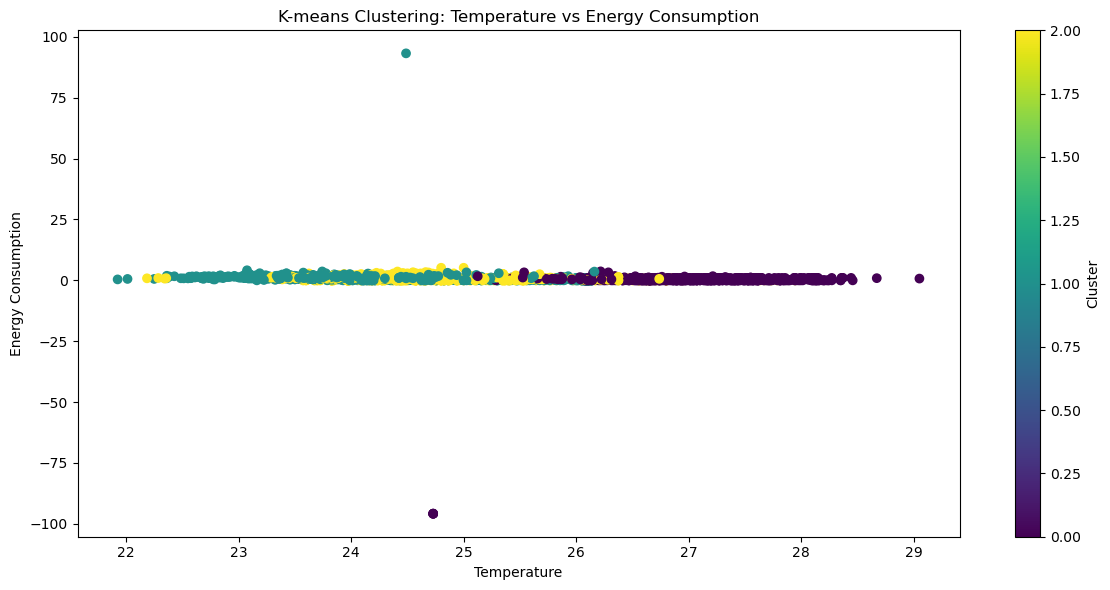

Cluster Centroids:
   energy_consumption  temperature   humidity  outdoor_temp  outdoor_humid
0           -0.258257    27.053998  70.315038     28.799342      74.987664
1            0.861617    24.267056  61.623593     27.789122      79.329341
2            0.691033    24.775046  57.051042     31.748910      63.690073

Cluster Distribution:
cluster
2    1239
1    1002
0     608
Name: count, dtype: int64


C:\Users\yy\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(
C:\Users\yy\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(
C:\Users\yy\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(
C:\Users\yy\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MK

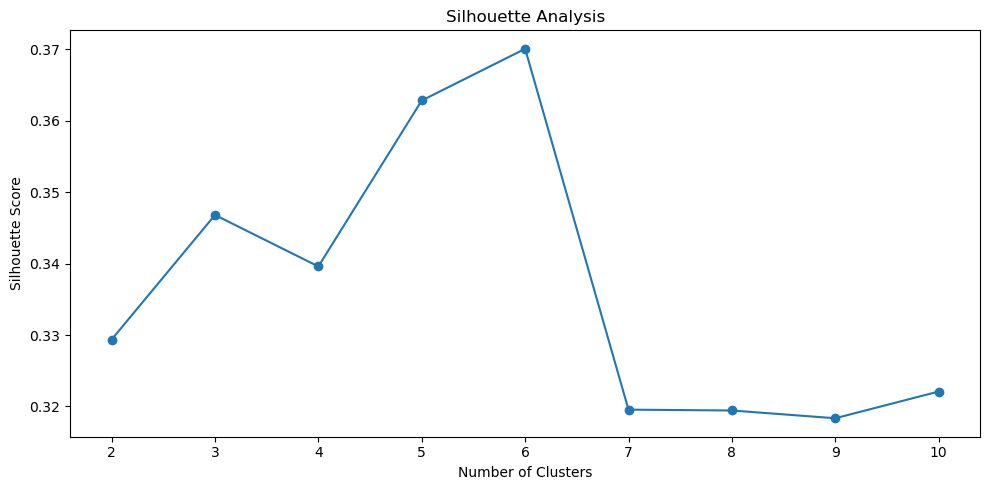

In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Read the CSV data
df = aircon_status_result

# Select features for clustering
features = [
    'energy_consumption', 
    'temperature', 
    'humidity', 
    'outdoor_temp', 
    'outdoor_humid'
]

# Prepare the data
X = df[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-means clustering
# We'll try 3 clusters as an example
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Visualize the clustering results
plt.figure(figsize=(12, 6))

# Plot energy consumption vs temperature, colored by cluster
plt.scatter(df['temperature'], df['energy_consumption'], 
            c=df['cluster'], cmap='viridis')
plt.xlabel('Temperature')
plt.ylabel('Energy Consumption')
plt.title('K-means Clustering: Temperature vs Energy Consumption')
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.show()

# Print cluster centroids
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
centroid_df = pd.DataFrame(centroids, columns=features)
print("Cluster Centroids:")
print(centroid_df)

# Cluster distribution
cluster_distribution = df['cluster'].value_counts()
print("\nCluster Distribution:")
print(cluster_distribution)

# Optional: Silhouette analysis to validate number of clusters
from sklearn.metrics import silhouette_score

# Try different numbers of clusters
max_clusters = 10
silhouette_scores = []

for n_clusters in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.tight_layout()
plt.show()